The data set is from the Kaggle web site will be used: https://www.kaggle.com/c/digit-recognizer/data
This data has a training.csv, test.csv and sample submission.csv files. <br>

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero
through nine.<br>

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each
pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel,
with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.<br>

The training data set, (train.csv), has 785 columns. The first column, called ”label”, is the digit
that was drawn by the user. The rest of the columns contain the pixel-values of the associated
image.<br>

Each pixel column in the training set has a name like pixel x, where x is an integer between
0 and 783, inclusive. To locate this pixel on the image, suppose that it has been decomposed x as
x = i ∗ 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixel x is located on
row i and column j of a 28 x 28 matrix, (indexing by zero).<br>

For example, pixel 31 indicates the pixel that is in the fourth column from the left, and the second
row from the top, as in the ascii-diagram below.<br>

This data is set up in a csv file which will require the reshaping of the data to be 28 × 28 matrix
representing images. There are 42000 images in the train.csv file. For this problem it is only
necessary to process approximately 100 images, 10 each of the numbers from 0 through 9. The
goal is to learn how to generate features from images using transforms and first order statistics.<br>

<b> 1. I first read-in and store the data so that the data is reshaped into a matrix of size 28 × 28 which represents each digit as an image.</b>

<b> 2.  Then I displayed the images for indices 0, 1, 3, 6, 7, 8, 10, 11, 16, and 21. These indices represent the numerical values from 0 to 9. </b>

In [1]:
# import additional libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import dataset
df = pd.read_csv('train.csv')

In [2]:
# Reshape the data into a 28x28 matrix
num_images = 100
image_size = 28
images = []
training_set=df.iloc[:,1:].to_numpy()

for i in range(num_images):
    label = df.iloc[i, 0]  # Get the label (digit)
    pixels = df.iloc[i, 1:]  # Get the pixel values
    image = np.array(pixels).reshape((image_size, image_size))  # Reshape to 28x28 matrix
    images.append((label, image))



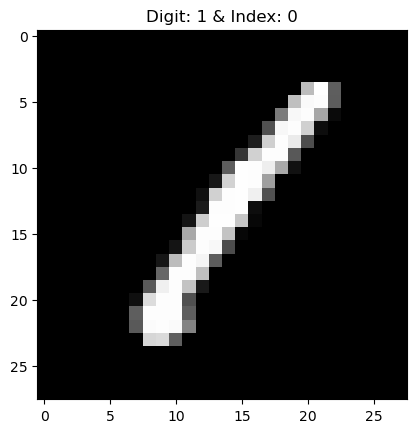

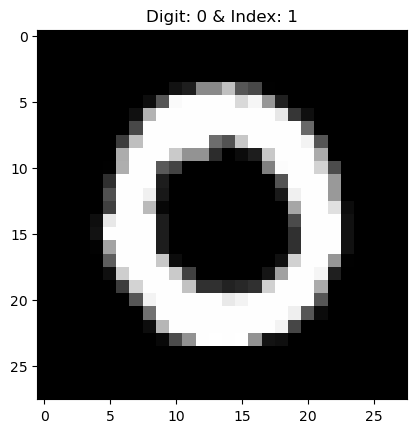

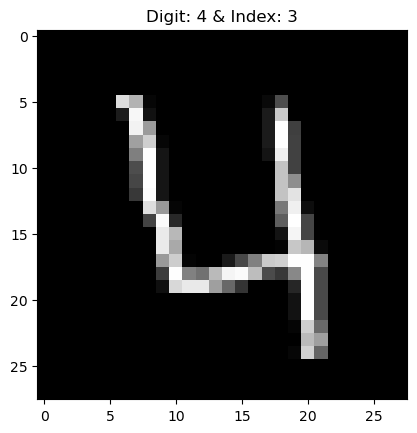

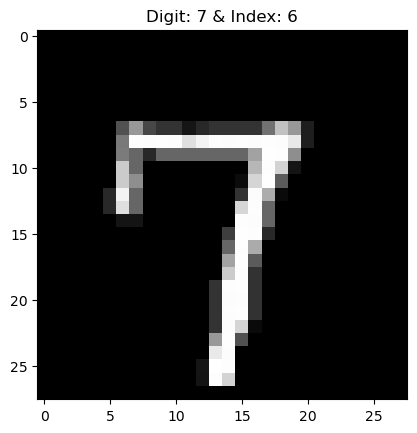

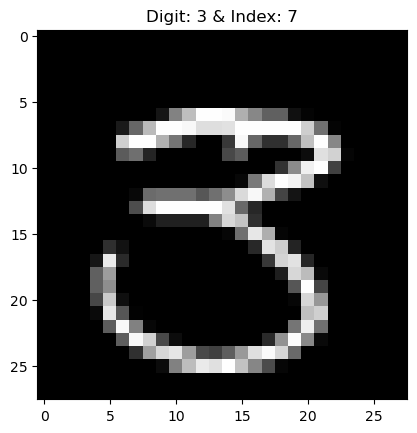

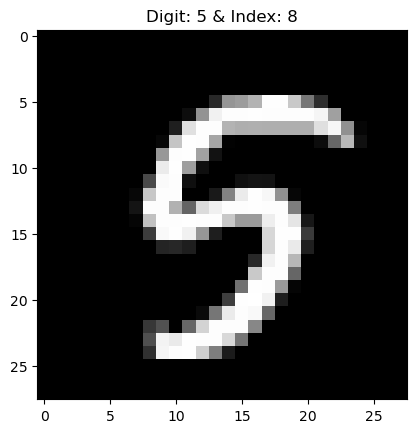

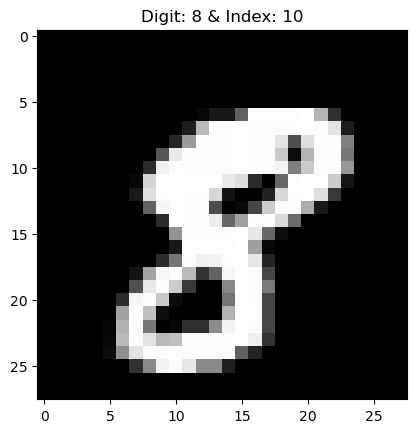

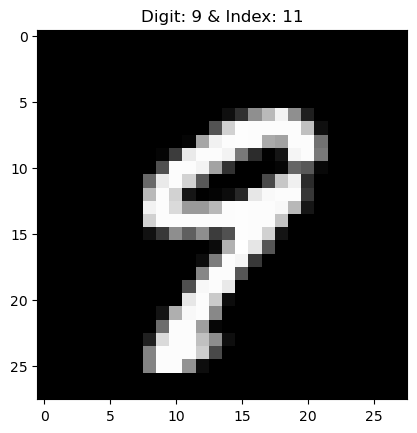

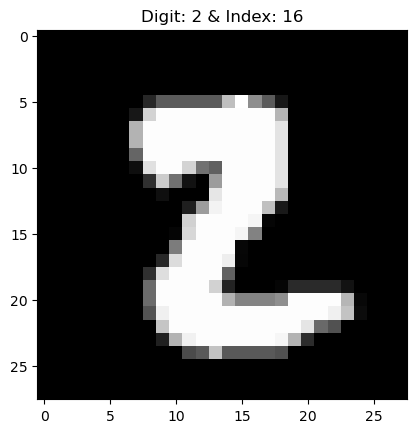

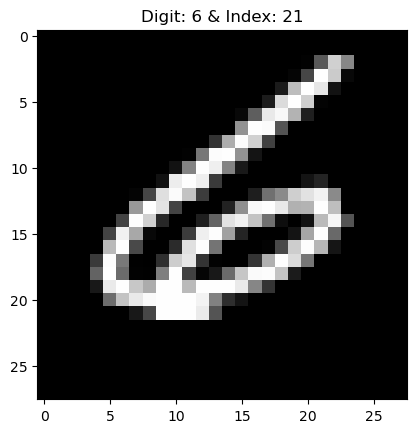

In [3]:
#Display the images for specific indices
indices_to_display = [0, 1, 3, 6, 7, 8, 10, 11, 16, 21]
images_digit = []

for index in indices_to_display:
    label, image = images[index]
    
    images_digit.append(image)
    
    plt.figure()
    plt.title(f"Digit: {label} & Index: {index}")
    plt.imshow(image, cmap='gray')
    plt.show()
    

Each image from the train.csv (42,000 images in total) is to be processed to generate a set of features using the <b> discrete cosine transform</b> and <b>Eigen decomposition</b>.

The steps are following: 

1. Take the **2 dimensional Discrete Cosine Transform (DCT)** of each matrix from the generated list of tuples above <br>
   Note that the matrix represents each number (0-9).'
   
2. Extract the vertical, horizontal and diagonal coefficients from the transform (using the indexes indicated by the masks provided).

3. For each of the three sets of DCT coefficients perform **Eigen decomposition**.

4. Retain the top 20 Eigen vectors of each direction.

5. Using the top Eigen vectors **reduce the DCT transformed data**.<br>
    This will createva new data set that represents each image as a smaller subset of values.

6. Save the new data in a file

In [4]:
def plot_pixels(pixel_arrays, title):
   # Determine the size m x n of subplots needed
    num_subplots = len(pixel_arrays)
    num_cols = 3
    num_rows = int(np.ceil(num_subplots / num_cols))
        
    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10,10), tight_layout=True)
    
    # Flatten the 2D array of axes for easier iteration
    axes = axes.flatten()

    for k in range(num_subplots):
        axes[k].set_title(f"Pixel {k}")
        axes[k].imshow(pixel_arrays[k], cmap="gray")# create subplot
        
        
    # Turn off any unused subplots
    for k in range(num_subplots, num_cols*num_rows):
        axes[k].axis('off')
    
    plt.suptitle(title)# Add superior 

    plt.show()

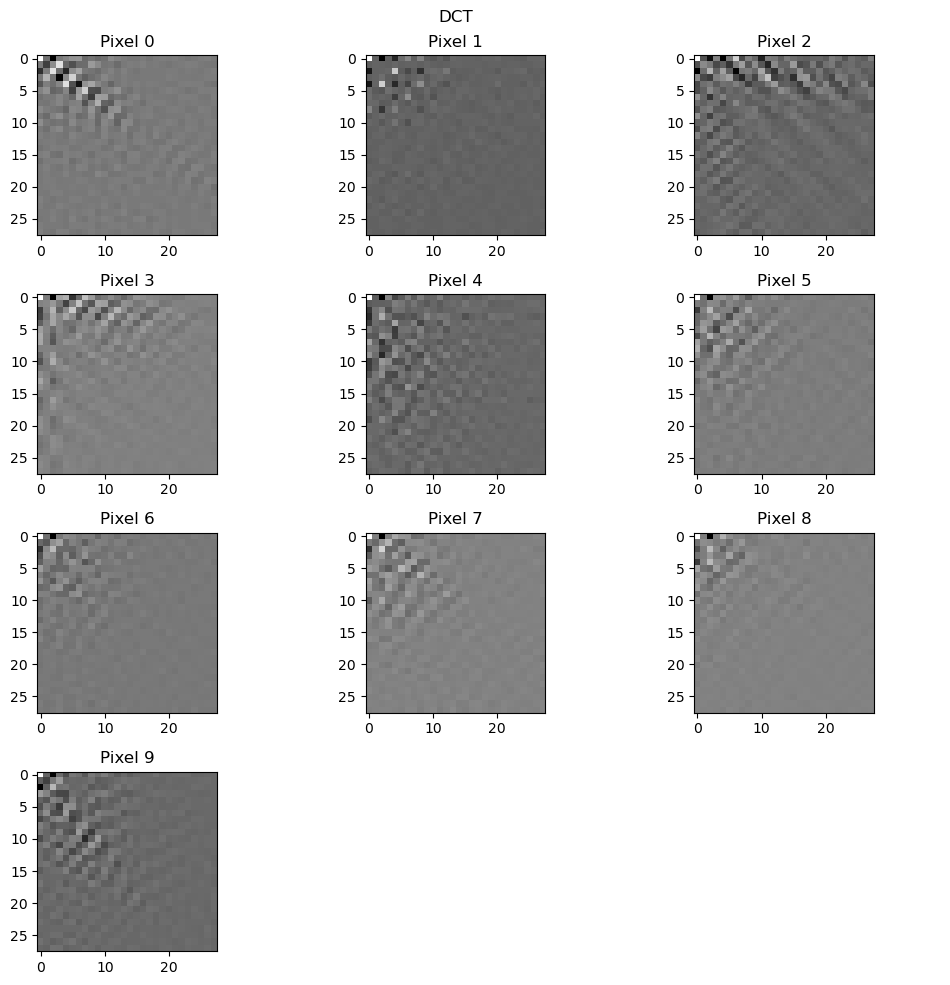

In [5]:
## 1 ##

import numpy as np
from scipy.fftpack import dctn

# 'images_digit' is the list of tuples generated above

# Take the 2D Discrete Cosine Transform (DCT)
dct_coefficients = []

for image in images_digit:
    dct_image = dctn(image, type=2, norm='ortho')
    dct_coefficients.append(dct_image)

plot_pixels(dct_coefficients, "DCT")


In [7]:
import numpy as np

with open('DCT_masks.txt', 'r') as file:
    content = file.read()

exec(content)

masks = [diagMask, vertMask, horizMask]
file_names = ['diagMask.csv', 'vertMask.csv', 'horizMask.csv']

# Save each mask as a separate CSV file
for file_name, mask in zip(file_names, masks):
    np.savetxt(file_name, mask, fmt='%d', delimiter=',')

diagMask.csv


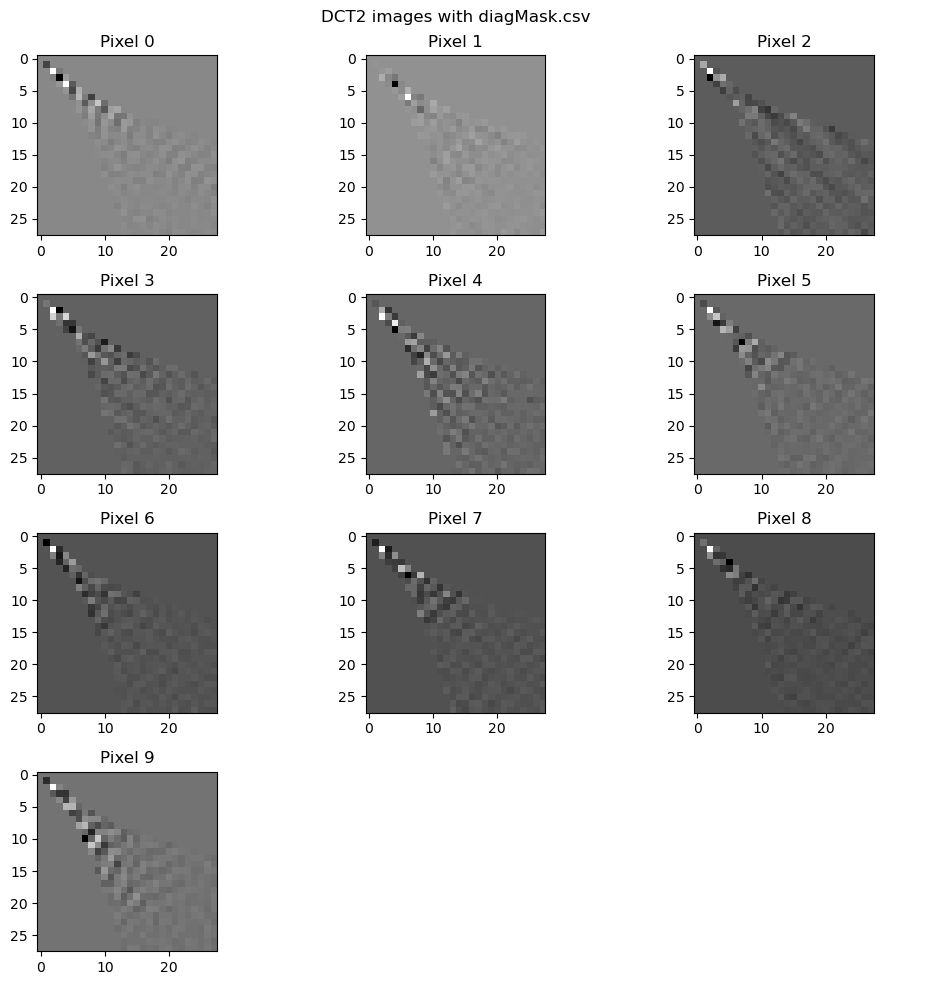

vertMask.csv


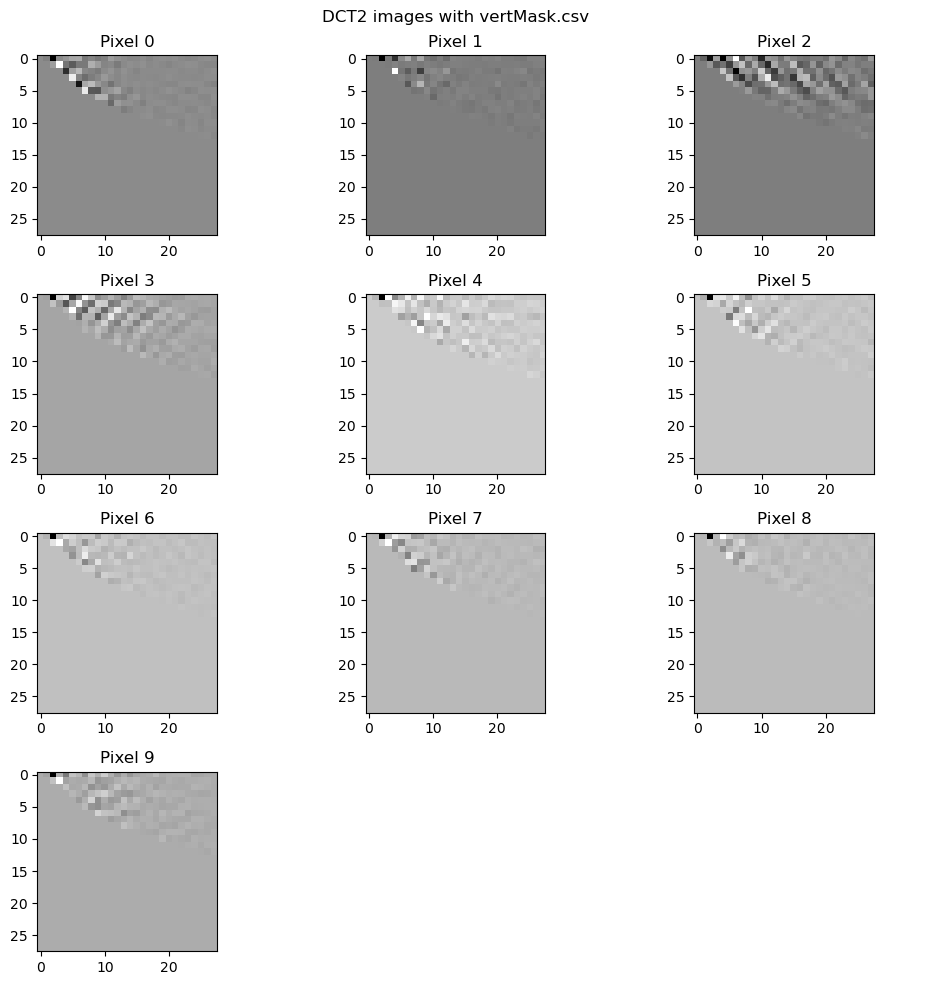

horizMask.csv


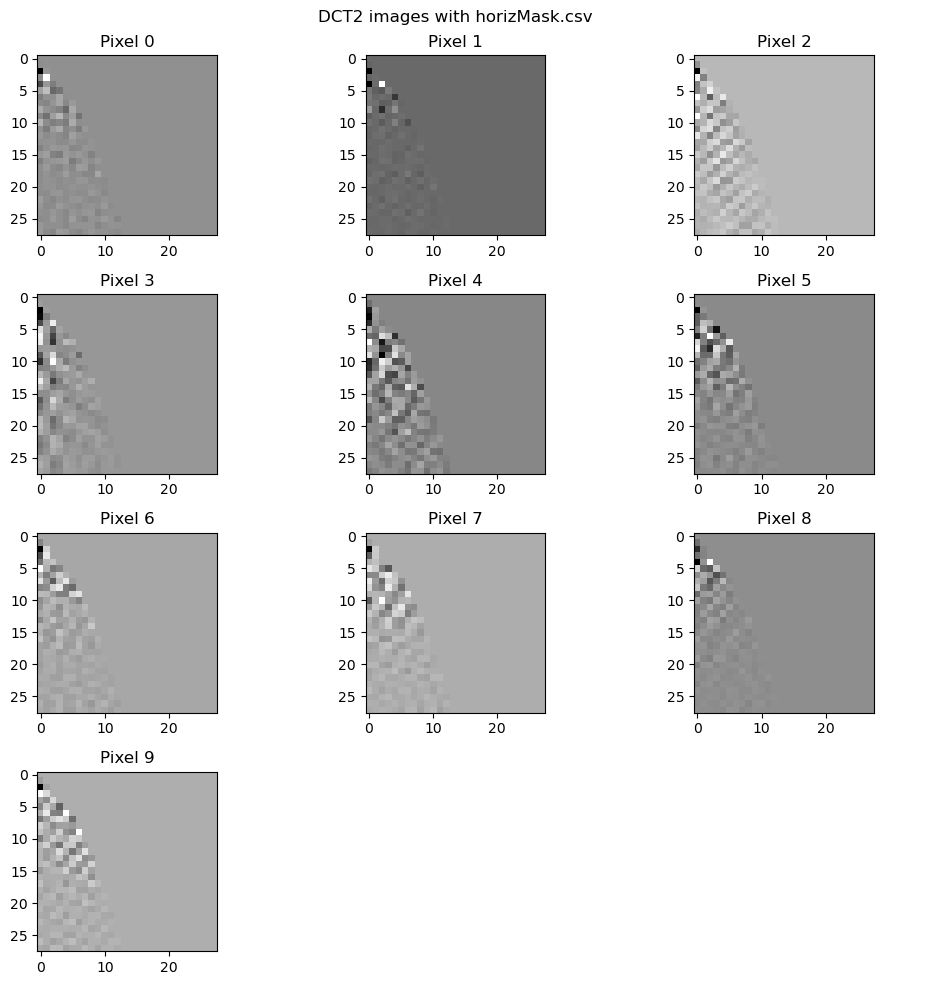

In [8]:
## 2 ##

bool_masks=[]
image_masked=[] 
file_names = ['diagMask.csv', 'vertMask.csv', 'horizMask.csv']

for file_name in file_names:
    # Load mask from CSV file
    print(file_name)
    this_mask = np.loadtxt(file_name, delimiter=",", dtype=bool)
    bool_masks.append(this_mask)

    # Apply mask to DCT coefficients and store in a list
    images_with_mask = [np.multiply(im, this_mask) for im in dct_coefficients]
    image_masked.append(images_with_mask)

    # Plot images
    plot_pixels(images_with_mask, title=f"DCT2 images with {file_name}")
    
# Now, masks contains the loaded masks, and image_masked contains the masked images.




In [9]:
## 3 ##

image_pixels = [training_set[i, :].reshape((28,28)) for i in range(42000)]
dct_coefficients = [dctn(pixel, type=2, norm="ortho") for pixel in image_pixels]
data_masked = [np.array([list(im[mask]) for im in dct_coefficients]) for mask in bool_masks]

import numpy as np

cov_data = []
eig_values = []
eig_vectors = []

# Loop through each masked matrix
for i, masked_matrix in enumerate(data_masked):
    
    # calculates the covariance matrix of the current masked matrix
    cov_data.append(np.cov(masked_matrix, rowvar=False))
    
    # eigen decomposition
    eig_values_i, eig_vectors_i = np.linalg.eig(cov_data[i])
    
    # Ensure eigenvalues are real
    eig_values_i = np.real(eig_values_i)
    eig_vectors_i = np.real(eig_vectors_i)
    
    eig_values.append(eig_values_i)
    eig_vectors.append(eig_vectors_i)

In [10]:
## 4 ##

top_eig_val=[]
top_eig_vec=[]

# top 20 
for i in range(len(eig_values)):
    top_eig_val.append(eig_values[i][:20])
    top_eig_vec.append(eig_vectors[i][:, :20])

In [11]:
## 5 ##

new_dataset = None

for i in range(len(data_masked)):
    new_feature = np.dot(data_masked[i], top_eig_vec[i]) 
    if new_dataset is None:
        new_dataset = new_feature
    else:
        new_dataset = np.append(new_dataset, new_feature, axis=1)


In [12]:
## 6 ##

# Create column labels, create dataframe and get number labels
reduced_feature_df = pd.DataFrame(new_dataset)
reduced_feature_df["digit"]=df["label"].iloc[:42000]
reduced_feature_df=reduced_feature_df[["digit"] + reduced_feature_df.columns[:-1].tolist()]

reduced_feature_df.to_csv("reduced_features.csv", index=False)

Now using the developed numerical features from previous code, performed the following steps: <br>

Use the **Fisher’s Linear Discriminant Ratio (FDR)**

1. For each feature and combination of numbers apply the FDR, e.g., 0 vs 1, 0 vs 2, ..., 0 vs 9, ..., 7 vs 8, 7 vs 9, and 8 vs 9 (which should result in a 60 x 45 matrix where 60 represents the number of features and 45 represents the number of pairwise comparisons).
2. Placed the results in a table and provided an initial analysis of which feature provides the best class separation.

In [13]:
import pandas as pd
train_features_file="trainFeatures42k.xls"
train_features_df=pd.read_excel(train_features_file, header=None)

column_labels = [f"{i}" for i in range(train_features_df.shape[1] - 1)]
column_labels=["digit",*column_labels]

train_features_df.columns=column_labels

In [14]:
## 1 ##

# get unique digit labels
digit_classifications = sorted(train_features_df["digit"].unique())

FDR_list = []
FDR_pairs_list = []

# Iterate over digit class pairs
for i in range(len(digit_classifications)):
    for j in range(i):
        class_i, class_j = digit_classifications[i], digit_classifications[j]
        FDR_pairs_list.append(f"{class_i}-{class_j}")
        this_FDR = []

        # Calculate FDR values for each feature
        for feature in train_features_df.columns[1:]:
            samples_i, samples_j = train_features_df[train_features_df["digit"] == class_j][feature], train_features_df[train_features_df["digit"] == class_i][feature]
            mean1, mean2 = samples_i.mean(), samples_j.mean()
            std1, std2 = samples_i.std(), samples_j.std()
            
            # The formula is: FDR = ((mean1 - mean2) ** 2) / (std1 ** 2 + std2 ** 2)
            this_FDR.append(((mean1 - mean2) ** 2) / (std1**2 + std2**2))

        FDR_list.append(this_FDR)

FDR_df = pd.DataFrame(FDR_list, columns=train_features_df.columns[1:])
FDR_df["Combination of #"] = FDR_pairs_list
FDR_df = FDR_df[["Combination of #"] + FDR_df.columns[:-1].tolist()]

print(FDR_df)

   Combination of #         0             1         2         3         4  \
0               1-0  2.186007  1.128549e-01  0.617201  0.011335  0.919689   
1               2-0  4.323050  2.376413e-01  0.509011  0.001052  0.679472   
2               2-1  0.200442  8.619509e-02  0.000751  0.002435  0.000020   
3               3-0  0.415880  2.017428e-01  2.908170  0.132721  1.061172   
4               3-1  0.534618  5.198250e-02  1.009532  0.230808  0.075066   
5               3-2  1.464421  5.276625e-03  0.933053  0.097109  0.044335   
6               4-0  2.507917  3.443897e-01  0.044496  0.016336  2.209851   
7               4-1  0.004375  2.138483e-01  1.029800  0.000387  1.065433   
8               4-2  0.314971  1.522620e-02  0.861960  0.004186  0.585679   
9               4-3  0.534519  4.275837e-02  3.741996  0.260229  0.352801   
10              5-0  0.308543  8.493357e-02  0.351140  0.018002  1.001736   
11              5-1  0.743904  1.304721e-07  0.025921  0.000463  0.036531   

In [15]:
## 2  ##

feature_ranking = FDR_df.iloc[:, 1:].sum(axis=0).sort_values(ascending=False)
# top 20 values
n = 20
top_features = feature_ranking.nlargest(n)

for i, (feature, ranking) in enumerate(top_features.items(), 1):
    print(f"{i}. Feature {feature}: {ranking}")


1. Feature 41: 79.84766759579652
2. Feature 40: 72.33031670374658
3. Feature 20: 68.21557275060519
4. Feature 2: 37.2743010969303
5. Feature 42: 33.94659732341022
6. Feature 0: 31.862545452664627
7. Feature 21: 25.776985513729233
8. Feature 22: 23.414576809892253
9. Feature 6: 22.192462945978495
10. Feature 4: 22.082269258077616
11. Feature 44: 20.635602852332035
12. Feature 3: 14.607027794788715
13. Feature 46: 12.540975391613154
14. Feature 43: 12.084676205427877
15. Feature 51: 11.210980100595089
16. Feature 11: 10.369896546830487
17. Feature 45: 9.599563709022824
18. Feature 7: 9.367734868066698
19. Feature 23: 8.573612719208029
20. Feature 1: 7.466148482638691


## analysis ##

The table above displays the top 20 features ranked by their respective Fisher's Discriminant Ratios (FDR). Each feature is denoted by a label and assigned a numeric ranking based on the degree of class separation it provides. A higher FDR value indicates a stronger discriminatory power.

Feature 41 claims the top position with an impressive FDR score of 79.85, showcasing its exceptional capability in distinguishing between classes. It is followed closely by Feature 40, which yields a substantial FDR of 72.33, further underlining its efficacy in class separation.

Feature 20 also emerges as a prominent contender, securing the third position with a notable FDR of 68.22. This indicates its significant contribution to the discriminative power of the dataset.

we can observe a gradual decline in FDR scores down the ranking list, indicating a diminishing level of class separation capability. 

In summary, Feature 41, Feature 40, and Feature 20 emerge as the standout contributors to class separation, demonstrating their important roles in distinguishing between classes of digits.